1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_auc_score, log_loss, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from prettytable import PrettyTable

In [221]:
#загрузим данные в датафрейм
df = pd.read_csv('train_case2.csv', ';')

In [222]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=21)

In [223]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]



In [224]:
class FeatureGenetator():
    """Генерация новых фич"""
    def __init__(self):
        pass
        
    def fit(self, X):
        pass
      
    def transform(self, X):
        
        # imt - индекс массы тела
        X['imt'] = X['weight']/(X['height']/100)**2
       
        return X

class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.imt_quantile_1 = None
        self.imt_quantile_99 = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет статистик
        self.imt_quantile_1 = X['imt'].quantile(.01)
        self.imt_quantile_99 = X['imt'].quantile(.99)
    
    def transform(self, X):
        """Трансформация данных"""
        #imt 
        cond1 = (X['imt'] < self.imt_quantile_1)
        cond2 = (X['imt'] > self.imt_quantile_99)
        X.loc[cond1, 'imt'] = self.imt_quantile_1 
        X.loc[cond2, 'imt'] = self.imt_quantile_99  
     
        return X

In [225]:
# делаем предобработку (создаем новые признаки и делаем препроцессинг данных)
features_gen = FeatureGenetator()
X_train = features_gen.transform(X_train)
X_test = features_gen.transform(X_test)

preprocessor = DataPreprocessing()
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [226]:
#Создадим трансформеры
continuos_cols = ['age', 'imt', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [227]:
#Объединим все наши трансформеры с помощью FeatureUnion
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

In [228]:
# создадим список, который будет хранить значения метрик
score = []
# будем максимизировать recall
b = 1.25

In [229]:
# Логистическая регрессия
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)

cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
log_los = log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])

# найдем индекс с максимальным fscore
ix = np.argmax(fscore)

score.append(['LogisticRegression', thresholds[ix] , fscore[ix], precision[ix], recall[ix], cv_score, roc_auc, log_los])

In [230]:
# Случайный лес
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestRegressor(random_state=42,
                                 criterion='mse',
                                 n_estimators=60,
                                 min_samples_split=2,
                                 min_samples_leaf=2,
                                 max_features='sqrt',
                                 max_depth=9,
                                 bootstrap=False)),
])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict(X_test)

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)

cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_test, y_score)
log_los = log_loss(y_test.values, y_score)

#найдем индекс с максимальным fscore
ix = np.argmax(fscore)

score.append(['RandomForest', thresholds[ix] , fscore[ix], precision[ix], recall[ix], cv_score, roc_auc, log_los])

In [231]:
# Градиентный бустинг
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingRegressor(random_state=42,
                                    n_estimators=60,
                                    min_samples_split=2,
                                    min_samples_leaf=2,
                                    max_features='sqrt',
                                    max_depth=5,
                                    criterion='mse')),
     ])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict(X_test)

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)

cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_test, y_score)
log_los = log_loss(y_test.values, y_score)

# найдем индекс с максимальным fscore
ix = np.argmax(fscore)

score.append(['GradientBoosting', thresholds[ix] , fscore[ix], precision[ix], recall[ix], cv_score, roc_auc, log_los])

In [232]:
mytable = PrettyTable()
mytable.align = "r"
values = ['threshold', 'fscore', 'precision', 'recall', 'cv score', 'roc auc', 'log loss']
for val in values:
    mytable.float_format[val] = ".5"
# имена полей таблицы
mytable.field_names = ['algoritm'] + values 
# добавление данных по одной строке за раз
for i in range(3):
    mytable.add_row([elem for elem in score[i]])
# вывод таблицы 
print(mytable)

+--------------------+-----------+---------+-----------+---------+----------+---------+----------+
|      algoritm      | threshold |  fscore | precision |  recall | cv score | roc auc | log loss |
+--------------------+-----------+---------+-----------+---------+----------+---------+----------+
| LogisticRegression |  0.32870  | 0.75918 |  0.60864  | 0.90197 | 0.78650  | 0.78436 | 0.57806  |
|    RandomForest    |  0.30213  | 0.76542 |  0.64037  | 0.87474 | 0.80119  | 0.80018 | 0.54330  |
|  GradientBoosting  |  0.29132  | 0.76472 |  0.63262  | 0.88269 | 0.80238  | 0.80145 | 0.54077  |
+--------------------+-----------+---------+-----------+---------+----------+---------+----------+


Видим, что лучше всех с задачей справилась модель градиентного бустинга (у нее лучшие показатели cv score, roc auc и log loss).

Предсказания градиентного бустинга
Confusion matrix, without normalization
[[4168 4518]
 [1035 7779]]


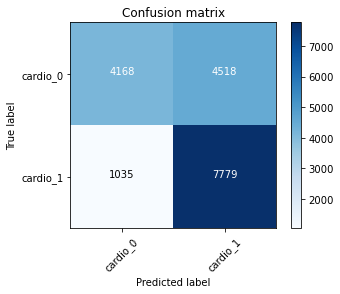

In [235]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print(f'Предсказания градиентного бустинга')
font = {'size' : 10}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, y_score>score[2][1])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()


In [236]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.882573179033356, 0.5201473635735666, 0.47985263642643333)

52 процента всех пациентов получат метку 1 (болен) при том, что они на самом деле здоровы.

В нашей задаче мы определяем, болен ли пациент (0 - здоров, 1 - болен), поэтому мы стараемся избежать ошибок false negative, требуя recall около 0.9. Можно сказать человеку, что он болен, и при дальнейшей диагностике выявить ошибку; гораздо хуже пропустить наличие болезни.

Рассмотрим задачу выделения объектов класса 1 из множества всех объектов (классов 1 и 0). Допустим, что всего имеется 1000100 объектов, из которых лишь 100 относятся к классу 1. Если нам удастся построить алгоритм, идеально решающий задачу, то его TPR будет равен единице, а FPR — нулю. Рассмотрим плохой алгоритм, дающий положительный ответ на 95 объектах класса 1 и 50000 - на объектах класса 0. Такой алгоритм совершенно бесполезен, но при этом имеет TPR = 0.95 и FPR = 0.05, что крайне близко
к показателям идеального алгоритма. Таким образом, если класс 1 существенно меньше по размеру класса 0, то
AUC-ROC может давать неадекватную оценку качества работы алгоритма, поскольку измеряет долю неверно принятых объектов относительно общего числа отрицательных. 